## Умова лабораторної роботи

### Моделі

`AdaBoostRegressor`. Розглянути рiзнi значення параметрiв `n_estimators`, `learning_rate` та `loss` цього алгоритму.


### Початкові дані

```python
sklearn.datasets.make_friedman2
```

### Завдання

1. Початковi 2D-данi представити графiчно.
2. Розбити данi на навчальний, перевiрочний та тестовий набори. Перевiрочний набiр використати для налаштування гiперпараметрiв. Тестовий набiр використати для остаточної оцiнки якостi моделей.
3. Побудувати ансамблi моделей.
    * В якостi `base_estimator` / `estimators` використати одну/ кiлька моделей iз параметрами по умовчанню: дерев рiшень, логiстичної регресiї, svm тощо.
    * Побудувати **графiки залежностi значень показника якостi ансамбля та iндивiдуальної моделi** вiд `n_estimators` на однiй координатнiй вiсi. Такий графiк для iндивiдуальної моделi, очевидно, буде горизонтальною прямою. В задачах регресiї показником якостi можна обрати `R2`, `MAPE` або `RMSE`.
4. Побудувати графiки на однiй координатнiй площинi (для регресiї):
    * прогнозiв на основi ансамблю,
    * прогнозiв на основi окремої моделi `base_estimator` / `estimators`,
    * точок даних з тестової множин.
5. Розрахувати **значення змiщення та дисперсiї** для окремої моделi та ансамблю.
6. Що можна сказати про **час навчання** ансамблю порiвняно з окремими моделями, якi утворюють цi ансамблi?
7. **Зробити висновки**. Чи краще на заданих даних виконується ансамбль порiвняно з iндивiдуальними моделями?

## Метрики якості

**R² (коефіцієнт детермінації)** - показує, наскільки добре модель пояснює варіацію залежної змінної $y$,  $R^2\in[0,1]$.
$$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

$ y_i $ — реальне значення, $ \hat{y}_i $ — прогнозоване значення, $ \bar{y} $ — середнє значення $ y $, $ n $ — кількість спостережень.


## Модель

`AdaBoost` — це алгоритм підсилення, який працює шляхом послідовного навчання слабких моделей (зазвичай це моделі, які мають трохи кращу точність, ніж випадкове вгадування, наприклад, неглибокі дерева рішень) на модифікованих версіях навчальних даних. Після цього результати всіх слабких моделей комбінуються за принципом зваженого голосування або суми для отримання остаточного прогнозу.

На кожній ітерації алгоритм змінює ваги навчальних зразків, що позначаються як $\omega_1, \omega_2, \ldots, \omega_n$. Спочатку всі ваги однакові: $\omega_i = 1/N$, де $N$ — кількість зразків, тому перша модель навчається на початкових даних.

На наступних ітераціях ваги змінюються залежно від того, як модель передбачила кожен зразок:
- ваги зростають для тих прикладів, які були передбачені неправильно;
- ваги зменшуються для тих, які були передбачені правильно.

Таким чином, кожна наступна слабка модель більше зосереджується на складних для передбачення прикладах. У результаті важкі приклади отримують більший вплив на процес навчання.

Основні параметри, які контролюють роботу алгоритму:
- `n_estimators` — кількість слабких моделей (ітерацій);
- `learning_rate` — визначає, наскільки сильно кожна слабка модель впливає на кінцевий результат;
- `estimator` — базова модель, яку використовують як слабкого учня (за замовчуванням це неглибокі дерева рішень);
- Параметри базової моделі, наприклад, `max_depth` (глибина дерева) або `min_samples_split` (мінімальна кількість зразків для поділу), також впливають на якість результату.

У підсумку, основна ідея полягає в тому, що слабкі моделі поступово покращуються, фокусуючись на помилках попередніх, а їхні прогнози комбінуються для побудови точної фінальної моделі.

##  Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_friedman2
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## EDA

Інформація про [дані](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_friedman2.html).

In [2]:
X, y = make_friedman2()

In [3]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (100, 4)
y shape: (100,)


Значення X[:,i], i=0,...,3 лежать на проміжках:
```python
0 <= X[:, 0] <= 100,
40 * pi <= X[:, 1] <= 560 * pi,
0 <= X[:, 2] <= 1,
1 <= X[:, 3] <= 11.
```
Значення y:
```python
y(X) = (X[:, 0] ** 2 + (X[:, 1] * X[:, 2]  - 1 / (X[:, 1] * X[:, 3])) ** 2) ** 0.5 + noise * N(0, 1).
```

## Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42
)

## Train

In [5]:
adaBoostRegr = AdaBoostRegressor(
    estimator= DecisionTreeRegressor(),
    n_estimators=50,
    learning_rate=0.7,
    loss="square"
)

decisionTreeRegr = DecisionTreeRegressor()

In [6]:
%%time
_ = decisionTreeRegr.fit(
    X_train,
    y_train
)

CPU times: total: 0 ns
Wall time: 5.03 ms


In [7]:
%%time

_ = adaBoostRegr.fit(
    X_train,
    y_train
)

CPU times: total: 438 ms
Wall time: 707 ms


## Evaluation

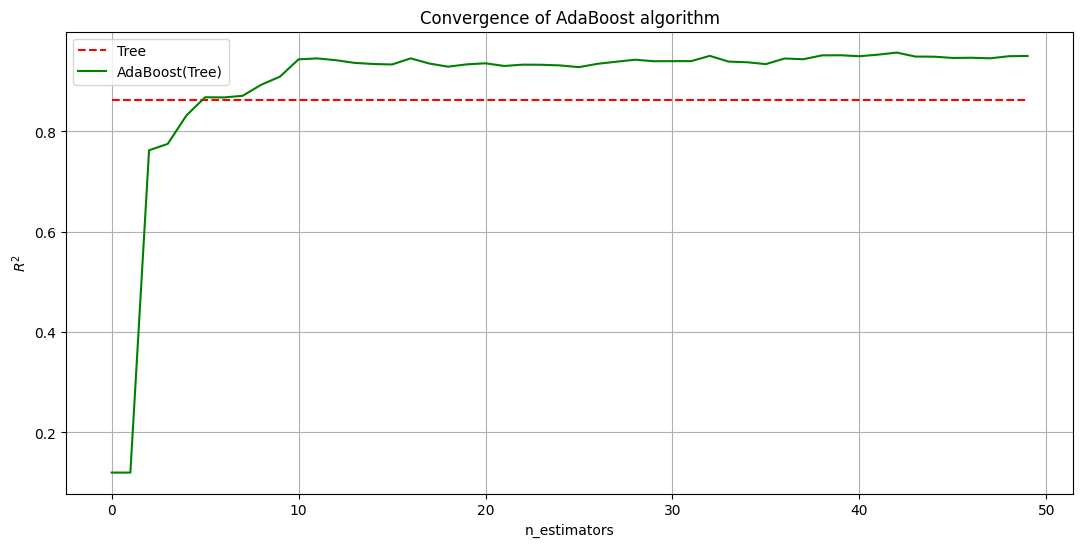

In [8]:
y_pred_adaBoostRegr = adaBoostRegr.predict(X_test)
y_pred_decisionTreeRegr = decisionTreeRegr.predict(X_test)

staged_adaBoostRegr_err = [
    r2_score(
        y_test,
        y_pred
    )
    for y_pred in adaBoostRegr.staged_predict(X_test)
]
decisionTreeRegr_err = r2_score(
    y_test,
    y_pred_decisionTreeRegr
)

plt.figure(figsize=(13,6))
plt.plot(
    np.arange(0,50),
    [decisionTreeRegr_err] * 50,
    label="Tree",
    color="red",
    linestyle="dashed"
)
plt.plot(
    staged_adaBoostRegr_err,
    label="AdaBoost(Tree)",
    color="green"
)
plt.legend()
plt.title("Convergence of AdaBoost algorithm")
plt.ylabel("$R^2$")
plt.xlabel("n_estimators")
plt.grid(True)

## Зміщення та дисперсія

Знайдемо [значення змiщення та дисперсiї](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html).

Tree: 27481.3063 (error) = 4415.2579 (bias^2)  + 23066.0875 (var) + 0.0098 (noise)
AdaBoost(Tree): 15478.6913 (error) = 5933.7624 (bias^2)  + 9544.9923 (var) + 0.0098 (noise)


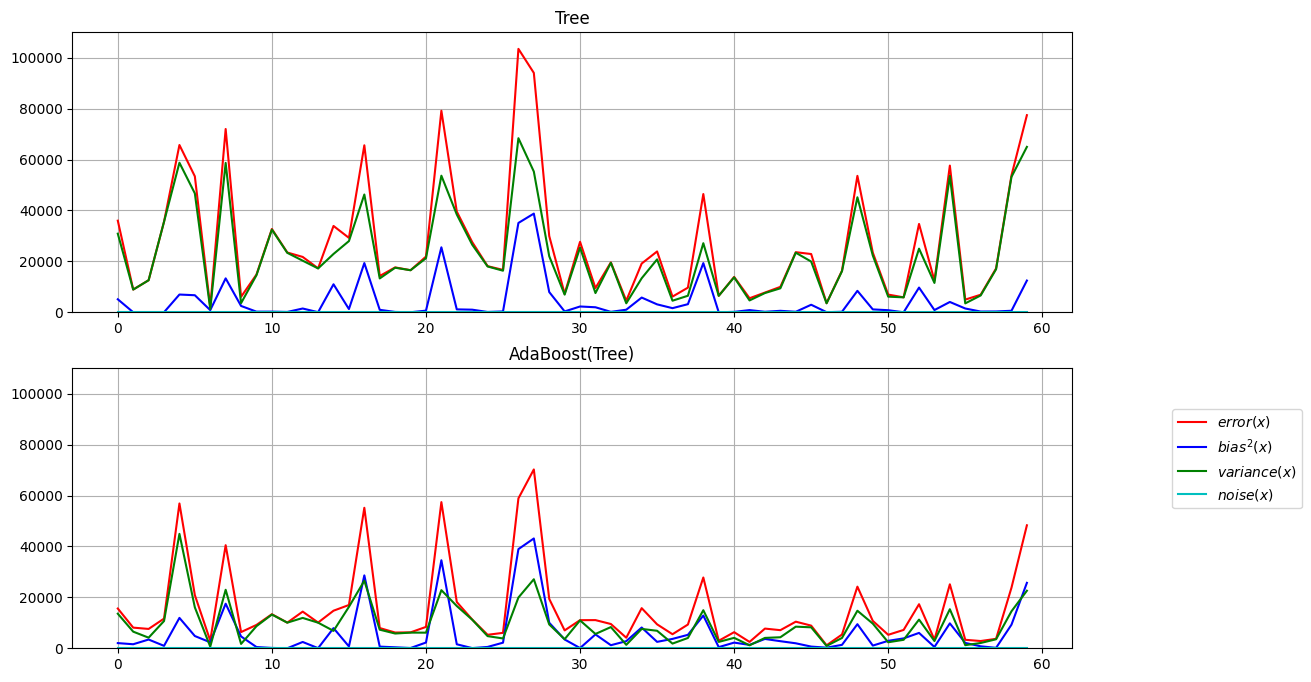

In [9]:
# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 40  # Size of the training set
n_test = 60  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("AdaBoost(Tree)", AdaBoostRegressor(
        estimator= DecisionTreeRegressor(),
        n_estimators=50,
        learning_rate=0.7,
        loss="square"
    )),
]

n_estimators = len(estimators)


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = make_friedman2(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y = make_friedman2(n_samples=n_test)
y_test = np.zeros((n_test, n_repeat))

for i in range(n_repeat):
    y_test[:, i] = y + np.random.normal(0.0, noise, n_test)

plt.figure(figsize=(16, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (y - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    plt.subplot(n_estimators, 1, n + 1)
    plt.title(name)
    plt.plot( y_error, "r", label="$error(x)$")
    plt.plot( y_bias, "b", label="$bias^2(x)$"),
    plt.plot( y_var, "g", label="$variance(x)$"),
    plt.plot( y_noise, "c", label="$noise(x)$")

    plt.ylim([0, 110000])
    plt.grid(True)


    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

## Висновки

Було досліджено роботу `AdaBoostRegressor` з `estimator=DecisionTreeRegressor`. За метрику якості обрано $R^2$. 

Виявилось, що ансамблевий метод краще справився за один екземпляр базової моделі. Проте тренування ансамблю зайняло більше часу ніж тренування однієї моделі. При невеликих даних це не дуже чутливо, проте при більшій кількості, потрібно реалізовувати більш кращі алгоритми для розв'язку задачі регресії.